In [34]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [35]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=54
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=52
nipd=int((et-st)/Bin_size)-irows-orows+1

In [36]:
# Data Preparation
import pandas as pd

# Selecting data based on bin size
#if Bin_size==0.5:
#    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_n&f.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Final_Results/Data/from_R_M1_1Hr_Model123.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [37]:
#Checking if the import is good to go:
Nos=332
if len(dataset)-1==Nos*18/Bin_size:
    print("Import successful!")

Import successful!


In [38]:
def giveme_dataset(rows,cols):
    for i in range(1,rows+1):
        print(dataset[i][:cols])
giveme_dataset(4,3)

[0.08259227 0.01696887 0.02251618]
[0.00654287 0.0388456  0.04031916]
[0.00663925 0.11435217 0.05657526]
[0.10327419 0.09795866 0.09841556]


In [39]:
print(irows,orows)
dataset[700:714]

3 1


array([[0.18833034, 0.81443671, 0.18620963, 1.        , 0.15749498,
        0.03798592, 0.03664699, 0.00785982, 0.83806308, 0.76383587,
        0.24290654, 0.31173163, 0.13825551, 0.34422577, 0.27309683,
        0.64402851, 0.96525567, 0.18948035, 0.7201827 , 0.29107896,
        0.37646065, 0.75230775, 0.57997849, 0.4091105 , 0.31520224,
        0.04784128, 0.96193834, 0.50498068, 0.15897527, 0.65113785,
        0.28064671, 0.1939301 , 0.10277763, 0.70336189, 0.5536743 ,
        0.40154674, 1.        , 0.27812678, 0.64845399, 0.56868454,
        1.        , 0.1952112 , 0.86906099, 0.45685515, 0.13628729,
        0.76354621, 0.17649881, 1.        , 0.21920479, 1.        ,
        0.38587905, 0.35807072, 0.5       , 0.84368152],
       [0.09418832, 0.31655481, 0.1213481 , 0.45367842, 0.15427392,
        0.27471193, 0.31989929, 0.59510664, 0.38528237, 0.29408065,
        0.2558897 , 0.19040811, 0.13380303, 0.24961515, 0.27393163,
        0.33169389, 0.50848856, 0.20598856, 0.49245195, 0.1

In [40]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

#Split a multivariate sequence into samples and put them into X and y
X, y = list(), list()
def split_sequences(sequences, n_steps_in, n_steps_out):
    #print(n_steps_in,n_steps_out)
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :-2]
        X.append(seq_x)
        y.append(seq_y)
    return None

n_steps_in, n_steps_out = int(irows), int(orows)
rows_pday=int((et-st)/Bin_size)

i=1
# convert into input/output
# Need to change to 34 or 35 or whatever when nrows in dataset change
for i in range(1,333):
    todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
    split_sequences(todays_df, n_steps_in, n_steps_out)


#Check if the io sample count is valid:
if len(X[1][1])==n_features and nipd*332==len(X)==len(y) and len(y[1][0])==52:
        print("IO Matrix creation successful!")
else:
    print("IO Matrix creation unsuccessful!",len(X[1][1])==n_features,nipd*332==len(X)==len(y),len(y[1][0])==52)

IO Matrix creation successful!


In [41]:
todays_df

array([[0.01820499, 0.19960714, 0.159845  , 0.11926222, 0.25767916,
        0.41931869, 0.39745475, 0.30075859, 0.44355244, 0.32486396,
        0.34923869, 0.34529557, 0.50814902, 0.45587668, 0.31700973,
        0.49053016, 0.3906829 , 0.2512082 , 0.54112842, 0.24423613,
        0.45079565, 0.49204182, 0.46941522, 0.36178257, 0.35269932,
        0.12583186, 0.30716668, 0.39329065, 0.45124016, 0.31187115,
        0.41106806, 0.42464191, 0.23362898, 0.23890104, 0.2509668 ,
        0.24055789, 0.41567114, 0.47680672, 0.31331437, 0.51646852,
        0.40927743, 0.51528175, 0.35231402, 0.43577639, 0.27678563,
        0.33873363, 0.33234814, 0.38670144, 0.23838445, 0.34610122,
        0.27616107, 0.17982709, 0.5       , 0.19357195],
       [0.02584165, 0.04366247, 0.03512752, 0.05370382, 0.11801035,
        0.12124261, 0.13431039, 0.03307728, 0.19723744, 0.3078284 ,
        0.1744403 , 0.20795645, 0.06035227, 0.28625387, 0.1626979 ,
        0.1463908 , 0.43296867, 0.21503062, 0.56370767, 0.2

In [42]:
seq=np.array([i for i in range(1,1001)])
seq_list=seq.reshape(100,10)
seq

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

In [43]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np
X_fil=np.array(X)
y_fil=np.array(y)
del_index=[]

# Noting down the index of Na matricesin del_index 
for i in range(len(X_fil)):
    del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))

# Filtering out the Na matrices from y_fil and X_fil by indexing using a list
y_fil=y_fil[list(~np.array(del_index))]
X_fil=X_fil[list(~np.array(del_index))]

# Check if the filtering is successful:
Na_count=0
for i in range(len(X_fil)):
    if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
        Na_count=Na_count+1
if Na_count==0:
    print("Na Matrices filtered out sucessfuly!")
# y=np.array(y)
# for el in y[list(~np.array(deathlist))]:
#     print(np.any(np.isnan(Xtrial[i])))


Na Matrices filtered out sucessfuly!


In [44]:
# Print number of IO Pairs available:
print(len(y_fil)," I/O pairs available.")

4980  I/O pairs available.


In [45]:
# Flatten output
n_output = y_fil.shape[1] * y_fil.shape[2]
y_fil = y_fil.reshape((y_fil.shape[0], n_output))

In [46]:
# Check the number of features
if n_features == X_fil.shape[2]:
    print("Good to go!")

Good to go!


In [47]:
X_fil[0][0]

array([0.08259227, 0.01696887, 0.02251618, 0.        , 0.14247434,
       0.0541817 , 0.        , 0.        , 0.14241473, 0.2310276 ,
       0.08110087, 0.04658413, 0.02769223, 0.08825611, 0.35091708,
       0.06197142, 0.37381297, 0.02945822, 0.31388774, 0.22652773,
       0.06315362, 0.        , 0.        , 0.        , 0.25605085,
       0.00113474, 0.01956254, 0.16241724, 0.        , 0.18195444,
       0.20033807, 0.14503682, 0.09063452, 0.05009552, 0.15646941,
       0.        , 0.        , 0.        , 0.10356036, 0.16720802,
       0.08219712, 0.03164317, 0.07138496, 0.2091732 , 0.        ,
       0.2986259 , 0.        , 0.        , 0.        , 0.21038104,
       0.08044518, 0.27520101, 1.        , 0.20452885])

In [48]:
# Splitting into train and test sets randomly
# np.random.seed(99)
# msk = np.random.rand(len(X_fil)) < 0.80

#Splitting taking the 4th to 9th days as the test set:
#Change this if day number changes
nipd=(rows_pday-irows-orows+1)
test_start=nipd*3
test_end=nipd*10
msk=[]
for i in range(332*(rows_pday-irows-orows+1)):
    if i<test_end and i>=test_start:
        msk.append(False)
    else:
        msk.append(True)

msk=np.asarray(msk)
X_train = X_fil[msk]
y_train = y_fil[msk]
X_test = X_fil[~msk]
y_test = y_fil[~msk]
print("Dataset splitting done!")

Dataset splitting done!


In [49]:
X_test

array([[[0.36486995, 0.190957  , 0.2193343 , ..., 0.45268014,
         0.        , 0.19357195],
        [0.15042128, 0.02860484, 0.06474073, ..., 0.62500402,
         0.        , 0.23648649],
        [1.        , 0.        , 0.04301833, ..., 0.07640038,
         0.        , 0.27392257]],

       [[0.15042128, 0.02860484, 0.06474073, ..., 0.62500402,
         0.        , 0.23648649],
        [1.        , 0.        , 0.04301833, ..., 0.07640038,
         0.        , 0.27392257],
        [0.09325643, 0.51755682, 0.44849585, ..., 0.55502222,
         0.        , 0.32213294]],

       [[1.        , 0.        , 0.04301833, ..., 0.07640038,
         0.        , 0.27392257],
        [0.09325643, 0.51755682, 0.44849585, ..., 0.55502222,
         0.        , 0.32213294],
        [0.02916969, 0.13798173, 0.05778976, ..., 0.16463497,
         0.        , 0.37764792]],

       ...,

       [[0.0763812 , 0.10686665, 0.05639693, ..., 0.65653634,
         0.5       , 0.73922571],
        [0.27226558, 

In [50]:
# multivariate output multi-step 1d cnn example
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
#model.add(Dense(500, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=4
# fit model
history=model.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Number or epochs:",epochno)
print("Number of input features:",n_features)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available:",len(y_fil))
print("Model Mape loss:",model.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

W0729 03:56:14.686779 139960410400576 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 03:56:14.688702 139960410400576 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 03:56:14.691803 139960410400576 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 03:56:14.720120 139960410400576 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W07

Number or epochs: 4
Number of input features: 54
Number of output features: 52
Bin size: 1
Window size: 3
Number of I/O pairs available: 4980
105/105 [==============================] - 0s 73us/step
Model Mape loss: 3090334.9714285713
105/105 [==============================] - 0s 94us/step
Model MSE loss (Minimized): 0.04537437991017387
105/105 [==============================] - 0s 69us/step
RMSE loss: 0.21301262852275654


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


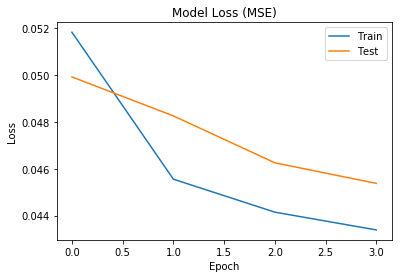

In [51]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [52]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [53]:
# import random
# #from plotnine import *
# rn=random.randint(1,150)
# # demonstrate prediction
# x_input = X[rn]
# y_output = y[rn]
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=1)
# pdt=yhat[0]
# act=y_output
# print(len(pdt))
# print(len(act))
# #library(ggplot2)
# #ggplot(, aes(x = drat, y = mpg)) + geom_point()

In [54]:
# Plot a random Prediction vs actual travel time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100)

#function to get the act and pdt values of a specified sample in the test set
def get_pdt_act(ind):
    #print(ind)
    # Demonstrate Prediction
    x_input = X_test[ind]
    x_input = x_input.reshape((1, irows, n_features))
    yhat = model.predict(x_input, verbose=0)
    y_output = y_test[ind]
    #print(len(yhat[0]))
    pdt=yhat[0]
    act=y_output
    if len(pdt)!=len(act):
        print("ERROR!")
    return pdt,act
norm_pdt,norm_act=get_pdt_act(0)

In [55]:
#print(dataset[4][:5])
print("\n\n ")
print(norm_act[:5])
#print(y_test[1][:5])

for i in range(100):
    if (norm_act==dataset[i][:52])[0]==True:
        print(i)
        print(dataset[i][:5])



 
[0.09325643 0.51755682 0.44849585 0.27043994 0.30728693]
58
[0.09325643 0.51755682 0.44849585 0.27043994 0.30728693]


In [56]:
dataset[4][:52]==norm_act

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

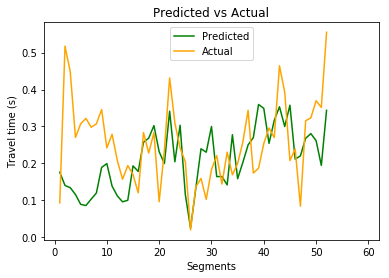

In [57]:
import matplotlib.pyplot as plt
import numpy

def plot_this(pdt_plt,act_plt):
    x=list(range(1,len(pdt_plt)+1))
    plt.plot(x, pdt_plt[0:], color='g',label="Predicted")
    plt.plot(x, act_plt[0:], color='orange',label="Actual")
    plt.xlabel('Segments')
    plt.ylabel('Travel time (s)')
    plt.title('Predicted vs Actual')
    axes = plt.gca()
    #axes.set_ylim([0,180])
    axes.set_xlim([-2,len(pdt_plt)+10])
    leg = plt.legend();
    plt.show()
plot_this(norm_pdt,norm_act)

In [58]:
#Scaling the IO values and then determining MSE and shit
import pandas as pd

# Selecting data min-max data
Minmax = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Minmax_M1.csv')


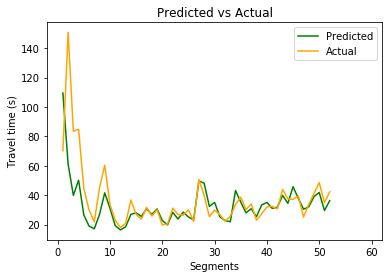

In [59]:
from sklearn.metrics import mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def denormalize(nor_pdt,nor_act):
    pdt_cor=[i for i in range(52)]
    act_cor=[i for i in range(52)]
    i=0
    for col in Minmax:
        mn=Minmax[col][1]
        mx=Minmax[col][0]
        pdt_cor[i]=(nor_pdt[i]*(mx - mn))+mn
        act_cor[i]=(nor_act[i]*(mx - mn))+mn
        i=i+1
    return pdt_cor,act_cor

denorm_pdt,denorm_act=denormalize(norm_pdt,norm_act)    
plot_this(denorm_pdt,denorm_act)

In [60]:
import matplotlib.pyplot as plt
import numpy

#function to get errror for any pdt and act
def get_error_pdt_act(pdt_err,act_err,printing=False):
    if printing==True:
        print("MSE Error:",mean_squared_error(pdt_err,act_err))
        print("RMSE Error:",np.sqrt(mean_squared_error(pdt_err,act_err)))
        print("MAPE Error:",mean_absolute_percentage_error(pdt_err,act_err))
    mse=mean_squared_error(pdt_err,act_err)
    rmse=np.sqrt(mean_squared_error(pdt_err,act_err))
    mape=mean_absolute_percentage_error(pdt_err,act_err)
    return mse,rmse,mape

get_error_pdt_act(denorm_pdt,denorm_act,False) 
print("MSE Error:",mean_squared_error(denorm_pdt,denorm_act))
print("RMSE Error:",np.sqrt(mean_squared_error(denorm_pdt,denorm_act)))
print("MAPE Error:",mean_absolute_percentage_error(denorm_pdt,denorm_act))


MSE Error: 281.52967933078975
RMSE Error: 16.778846185920823
MAPE Error: 21.18217125649377


In [61]:
#Iterating over all tensors in test set
#Check if lengths match:
if X_test.shape[0]==y_test.shape[0]:
    print("Good to go!")
else:
    print("Lengths dont match!")

MSE_list=[]
RMSE_list=[]
MAPE_list=[]
pdt_list=[]
act_list=[]

total_test=X_test.shape[0]
for ind in range(total_test):
    norm_pdt,norm_act=get_pdt_act(ind)
    denorm_pdt,denorm_act=denormalize(norm_pdt,norm_act)
    pdt_list.append(denorm_pdt)
    act_list.append(denorm_act)
    MSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[0])
    RMSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[1])
    MAPE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[2])

mean_MSE=sum(MSE_list)/len(MSE_list)
mean_RMSE=sum(RMSE_list)/len(RMSE_list)
mean_MAPE=sum(MAPE_list)/len(MAPE_list)    

print("\n")
print("Model - 2")
print("Overall MSE",mean_MSE)
print("Overall RMSE",mean_RMSE)
print("Overall MAPE",mean_MAPE)

Good to go!


Model - 2
Overall MSE 500.8019319668307
Overall RMSE 19.64534088067908
Overall MAPE 22.759557824398296


In [62]:
# Creating a dataframe out of the tt lists
predicted_df=pd.DataFrame(pdt_list)
actual_df=pd.DataFrame(act_list)

In [63]:
#Saving the dataframes as csv tables.
predicted_df.to_csv("Model2_v2_pdt_M1.csv")
actual_df.to_csv("Model2_v2_act_M1.csv")